In [1]:
import cv2
import math
import numpy as np
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = [15, 10]

(<AxesSubplot: >, <matplotlib.image.AxesImage at 0x19503e47460>)

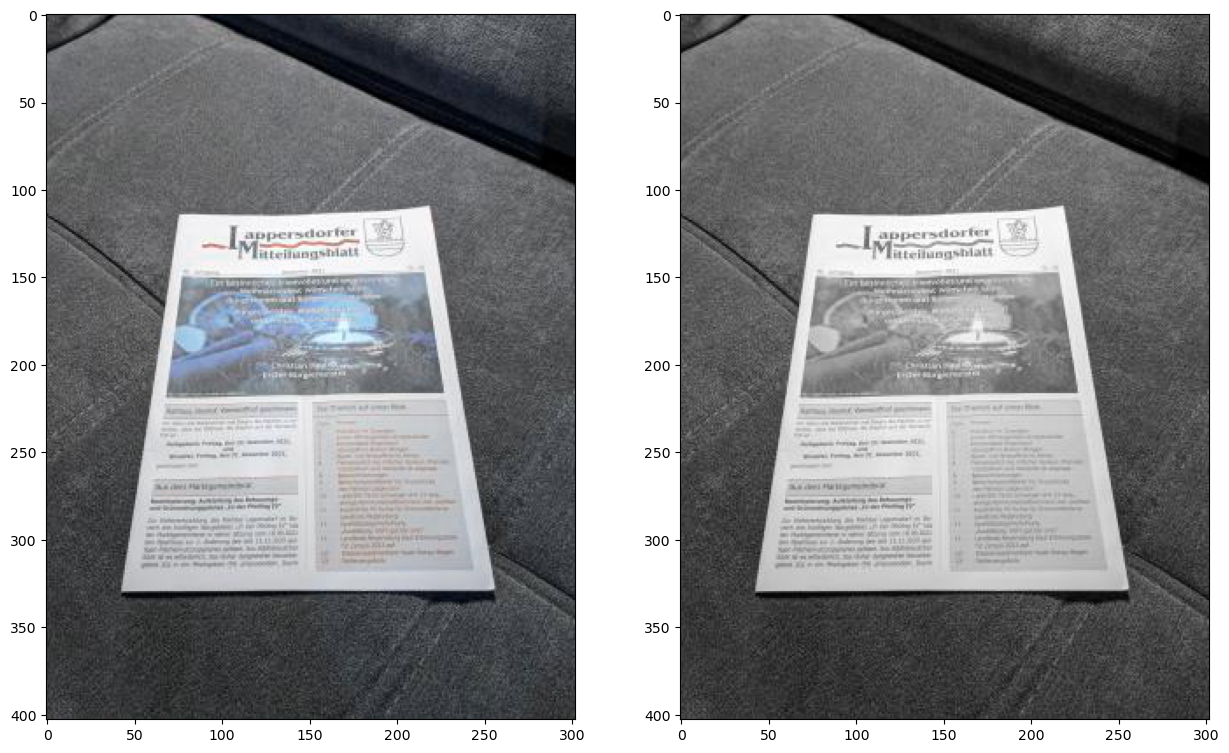

In [2]:
# Let's read the image
img = cv2.imread('desktop/document.jpg')
# Convert it to gray scale
gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
#gray = np.float32(gray)/255
gray = gray.astype(np.float32)/255
rows, cols = gray.shape

# Let's plot the images (colour and gray scale)
plt.subplot(121), plt.imshow(img)
plt.subplot(122), plt.imshow(gray, cmap='gray')

(<AxesSubplot: >, <matplotlib.image.AxesImage at 0x19503ee7d90>)

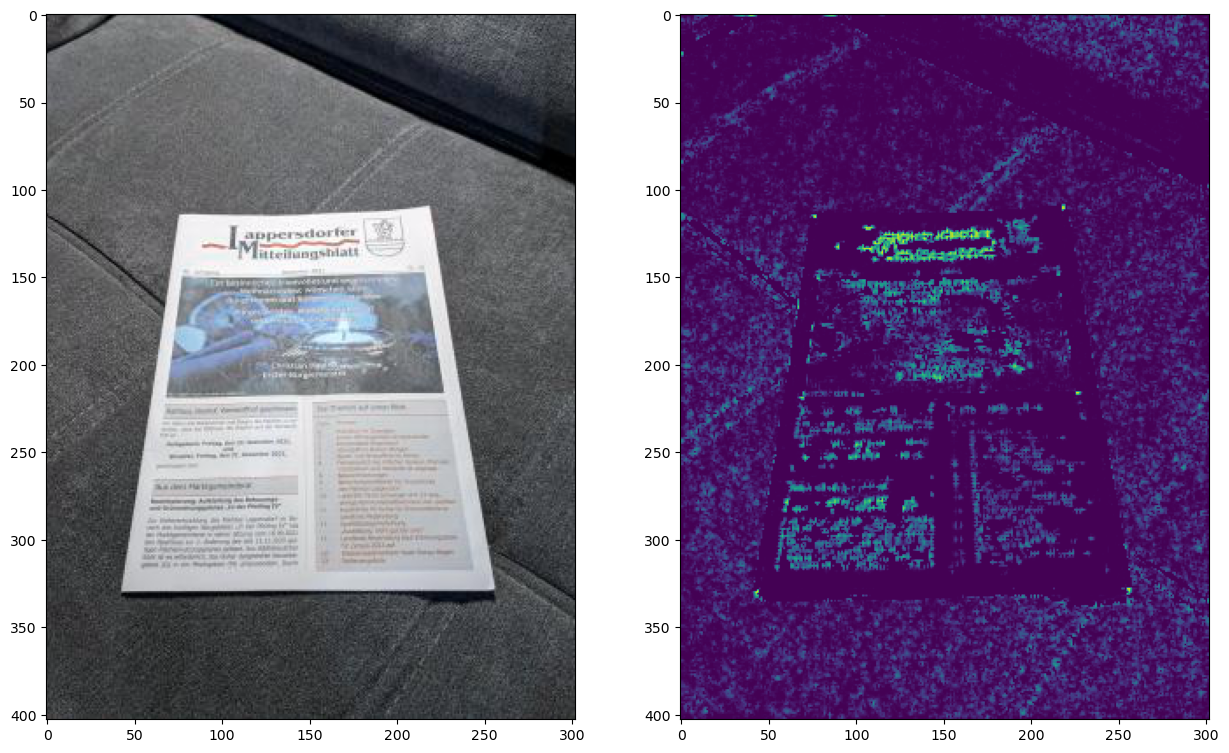

In [3]:
# Compute Harris corners (use the available OpenCV functions)
# Suggested parameters:
#            block size of 2 pixels
#            gradient kernel size of 3 pixels
#            k parameter equal to 0.04
cornerness = cv2.cornerHarris(gray, blockSize=2, ksize=3, k=0.04)

# We are not interested in edges, so put to zero all negative cornerness values
#cornerness = cornerness*(cornerness>0) 

cornerness = cornerness.clip(min=0)

# Since cornerness has a huge dynamic range, let's take the logarithm for better visualization and manipulation
cornerness = np.log(cornerness + 1e-6)
#cornerness = cv2.dilate(cornerness, None)
#img[cornerness > 0.01 * cornerness.max()] = [0, 255, 0]

# Let's now plot the image and the corresponding Harris corners (in log scale)
plt.subplot(121), plt.imshow(img)
plt.subplot(122), plt.imshow(cornerness)

(<AxesSubplot: >, <matplotlib.image.AxesImage at 0x1950508fdc0>)

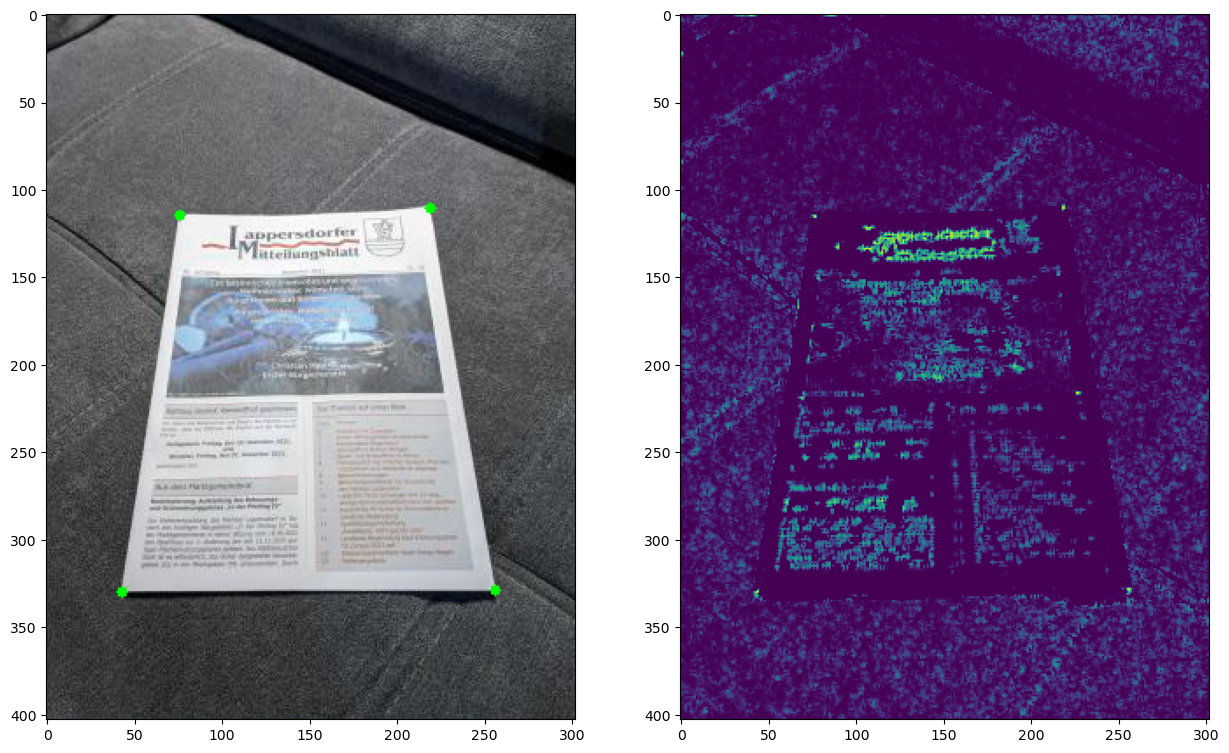

In [6]:
# Detection thresholds
th_top_left, th_top_right = -1e6, -1e6
th_bottom_left, th_bottom_right = -1e6, -1e6

# Corner coordinates
opt_top_left, opt_top_right = None, None
opt_bottom_left, opt_bottom_right = None, None

# Size of each quadrant (in pixels)
quad_size = 7

# Let's now scan the Harris detection results
for r in range(quad_size, rows-quad_size):
    for c in range(quad_size, cols-quad_size):
        # Edges with too small cornerness score are discarded, -7 seems like a good value
        if cornerness[r, c] < -7:
            continue
        
        # Extract block consisting of 4 quadrants
        block = 255*gray[r-quad_size:r+quad_size+1, c-quad_size:c+quad_size+1]
        
        # Extract the four quadrants
        quad_top_left = block[0:quad_size, 0:quad_size]
        #print(quad_top_left)
        
        quad_top_right = block[0:quad_size, quad_size+1:(2*quad_size)]
        #print(quad_top_right)
        
        quad_bottom_left = block[quad_size+1:(2*quad_size), 0:quad_size]
        #print(quad_bottom_left)
        
        quad_bottom_right = block[quad_size+1:(2*quad_size), quad_size+1:(2*quad_size)]
        #print(quad_bottom_right)
        
        # Top-left corner
        # For the top-left document corner, the bottom-right quadrant is mostly paper and the rest is
        # darker background. Therefore, I suggest the descriptor to be the average difference between
        # the paper quandrant and the sum of the 3 remaining bakcground quandrants
        
        descriptor = np.mean(quad_bottom_right) - \
                     np.mean(quad_top_left) - np.mean(quad_top_right) - np.mean(quad_bottom_left)
        # Let's detect the best descriptor
        if descriptor > th_top_left:
            # We update the threshold
            th_top_left = descriptor
            # And we update the optimal location
            opt_top_left = (c, r)
            
        # Top-right corner
        descriptor = np.mean(quad_bottom_left) - \
                     np.mean(quad_top_left) - np.mean(quad_top_right) - np.mean(quad_bottom_right)
        
        if descriptor > th_top_right:
            th_top_right = descriptor
            opt_top_right = (c, r)
        
        # Bottom-left corner
        descriptor = np.mean(quad_top_right) - \
                     np.mean(quad_top_left) - np.mean(quad_bottom_right) - np.mean(quad_bottom_left)
        
        if descriptor > th_bottom_left:
            th_bottom_left = descriptor
            opt_bottom_left = (c, r)  
        
        # Bottom-right corner
        descriptor = np.mean(quad_top_left) - \
                     np.mean(quad_bottom_right) - np.mean(quad_top_right) - np.mean(quad_bottom_left)
        
        if descriptor > th_bottom_right:
            th_bottom_right = descriptor
            opt_bottom_right = (c, r)

# Let's draw circles at the detected corners
out = cv2.circle(img, opt_top_left, 3, (0,255,0), -1)
out = cv2.circle(img, opt_top_right, 3, (0,255,0), -1)
out = cv2.circle(img, opt_bottom_left, 3, (0,255,0), -1)
out = cv2.circle(img, opt_bottom_right, 3, (0,255,0), -1)

# And finally we plot the images (with the detected document corners)
plt.subplot(121), plt.imshow(out)
plt.subplot(122), plt.imshow(cornerness)

In [8]:
print(opt_top_left)
print(opt_top_right)
print(opt_bottom_left)
print(opt_bottom_right)

(76, 115)
(219, 111)
(43, 330)
(256, 329)


# Questions
### 1) Does it matter whether the picture has been taken by a 1Mpx camera or a 12Mpx camera? How?

I think yes, it matters because at least we change the resolution of the image, that is, the number of rows and cols. Also, due to the increase in detail, we may have an increase in the amount of extra "garbage" on image that will interfere with detecting the corners of the document, and, possibly, some related minor problems, such as the speed of the loop and problems with storing files of such volumes.

### 2) If we increased the resolution of the camera, what would you change in the current algorithm?

It seems to me that the higher the resolution, the larger the size of the quadrants we can initially set in order to optimize the speed of work. And setting the minimum allowable angularity value for edges (in this case it was -7)